In [ ]:
import sys
import os

# add project root directory to sys.path
sys.path.append("./PosFormer")

In [22]:
import numpy as np
import torch
import os
from pytorch_lightning import LightningModule
from PIL import Image
from PIL import ImageOps
import torchvision.transforms as transforms
from PosFormer.Pos_Former.lit_posformer import LitPosFormer
from PosFormer.Pos_Former.datamodule.transforms import ScaleToLimitRange
from PosFormer.Pos_Former.datamodule import vocab

# vocab.init("PosFormer/Pos_Former/datamodule/dictionary.txt.txt")
torch.cuda.is_available()
device = torch.device('cuda:0')


K_MIN = 0.7
K_MAX = 1.4

H_LO = 16
H_HI = 256
W_LO = 16
W_HI = 1024
threshold = 128
transform = transforms.Compose([ScaleToLimitRange(w_lo=W_LO, w_hi=W_HI, h_lo=H_LO, h_hi=H_HI),
    transforms.ToTensor()])

def load_and_preprocess_image(image_path, device):
    # image = np.array(Image.open(image_path).convert('L'))
    image = ImageOps.invert(Image.open(image_path).convert('L'))
    image = np.array(image)
    image = (image >= threshold).astype(np.uint8) * 255
    image_tensor = transform(image)
    img_mask = torch.zeros(image_tensor.shape, dtype=torch.bool, device=device)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    return image_tensor, img_mask

class TonyPosFormerModel(LightningModule):
    def __init__(self, checkpoint_path=None):
        super().__init__()
        self.model = LitPosFormer(d_model=256,
                growth_rate=24,
                num_layers=16,
                nhead=8,
                num_decoder_layers=3,
                dim_feedforward=1024,
                dropout=0.3,
                dc=32,
                cross_coverage=True,
                self_coverage=True,
                beam_size=10,
                max_len=200,
                alpha=1.0,
                learning_rate=1.0,
                early_stopping=False,
                temperature=1.0,
                patience=20)
        if checkpoint_path:
            self.load_weights(checkpoint_path)
        print(self.model.hparams)
        
    def load_weights(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        self.model.load_state_dict(checkpoint['state_dict'])
        
        self.model = self.model.to(device)
    
    def inference(self, img_path: str,):
        # Prepare Data
        img_tensor, img_mask = load_and_preprocess_image(img_path, device)
        self.model.eval()
        with torch.no_grad(): 
            hypotheses = self.model.approximate_joint_search(img_tensor, img_mask)
            preds = [vocab.indices2words(h.seq) for h in hypotheses]
        return preds




"alpha":              1.0
"beam_size":          10
"cross_coverage":     True
"d_model":            256
"dc":                 32
"dim_feedforward":    1024
"dropout":            0.3
"early_stopping":     False
"growth_rate":        24
"learning_rate":      1.0
"max_len":            200
"nhead":              8
"num_decoder_layers": 3
"num_layers":         16
"patience":           20
"self_coverage":      True
"temperature":        1.0


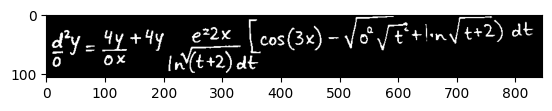

\frac{d^{0}y=\frac{d^{2}}{4x}+4y+\frac{e^{2x}{(t+2)}dt}(\cos(3x)-\sqrt{0^{a}\sqrt{t^{2}+\lim\sqrt{t+2)dt


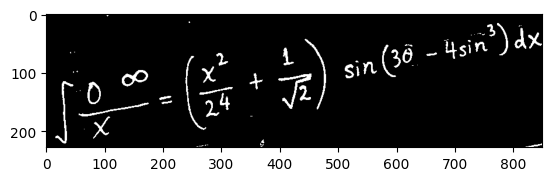

\int\limits_{i}^{0}\frac{x^{2}}{x}=(\frac{1}{2^{4}}+\frac{1}{\sqrt{2}})\sin(3\theta-4\sin^{3})dx}


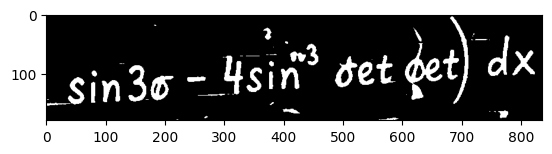

\lim\limits_{n\rightarrow0}-4\cdot\frac{3}{3}\cdot\lim\limits_{m3}8ek\phi_{n}\phi_{k})^{2}dx


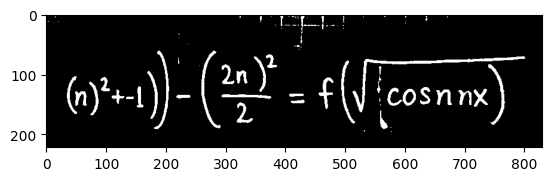

(n)^{2}+1)^{i}(\frac{2n)^{2}}{(\frac{1}{i-1}}=f(\frac{1-1}{\frac{1}{i\cdot!}{2}\sin(nx)}


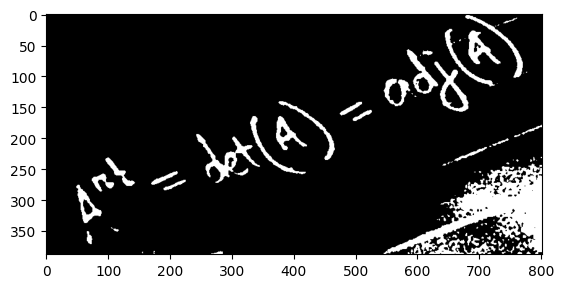

\sum\limits_{n}^{s_{i}}=x^{\sum\limits_{i}}(\frac{s_{i}}{n,\ldots)^{2}}{\cdots+s_{i}}\cdot(\frac{n,j\prime\sin(j\prime\sin^{\frac{j}{1}})}


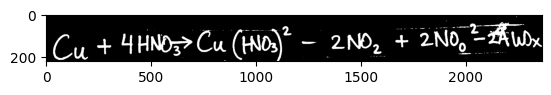

C_{u}+4N_{3}>C_{u}(1N_{3})^{2}-2N_{0}-2N_{2}ij_{i}^{-2}-\sumAA_{0}^{\cdots+\infty}


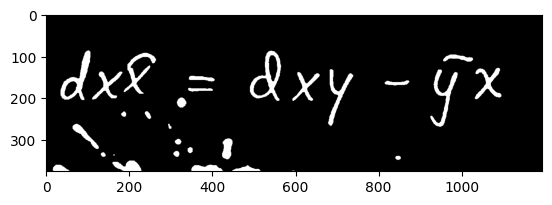

\lim\limits_{x\rightarrow0}=dx_{0}\cdoty-y\timesyx


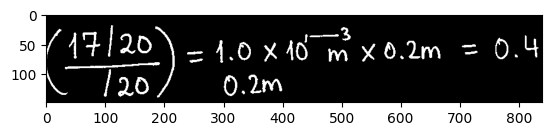

(\frac{17/20}{120})=1.0\times10^{1-2m^{3}\times0.2m=0.4}


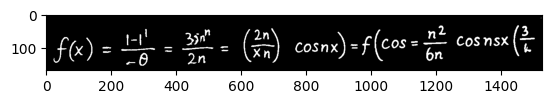

f(x)=\frac{1-1)^{n}}{2n}=(\frac{2n}{xn})=f(\cosx)=\frac{n^{2}}{6n}\cos(\frac{3}{k}


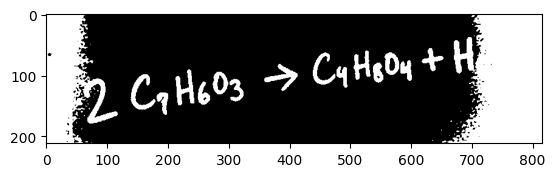

\lim\limits_{\frac{\sum\limits_{3}\theta_{4}}{4}+\ldots+\lim\limits_{\cdots+\lim\limits_{\frac{1}{4}\prime\sin^{\frac{1}{4}+\beta_{4}})=\beta


In [24]:
ckpt_path = 'PosFormer/lightning_logs/version_0/checkpoints/best.ckpt'
img_folder = './nano-banana-images'
model = TonyPosFormerModel(checkpoint_path=ckpt_path)
for img in os.listdir(img_folder):
    img_path = os.path.join(img_folder, img)
    img = ImageOps.invert(Image.open(img_path).convert('L'))
    img = np.array(img)
    img= (img >= threshold).astype(np.uint8) * 255
    from matplotlib import pyplot as plt
    plt.imshow(img, cmap='gray')
    plt.show()
    preds = model.inference(img_path)
    print("".join(preds[0]))